## Financial Time Series and Their Characteristics

Both financial theory and its empirical time series contain an element of uncertainty. For example, there are various definitions of asset volatility, and for a stock return series, __the volatility is not directly observable__. As a result of the added uncertainty, statistical theory and methods play an important role in financial time series analysis.

In this lecture, we will study:

* asset returns
* descriptive statistics of returns
* distributional properties of returns

In [81]:
import numpy as np
import scipy
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

### The Time Value of Money

Future value, present value and simple interest:

$$FV_n = V(1+R) \times \cdots \times (1+R) = V \cdot (1+R)^n$$

$$PV = \frac{FV_n}{(1+R)^n}$$

$$n = \frac{\ln(FV_n /V)}{\ln(1+R)} $$

It is very easy to calculate how long it will take to double the value.

In [16]:
r = [r/100 for r in range(1, 11)]
year = [math.log(2)/math.log(1+i) for i in r]
appro_year = [0.7/i for i in r]  # rule of 70
print(tabulate(zip(r, year, appro_year), headers=['R', 'Years', "Approximate Years"]))

   R     Years    Approximate Years
----  --------  -------------------
0.01  69.6607              70
0.02  35.0028              35
0.03  23.4498              23.3333
0.04  17.673               17.5
0.05  14.2067              14
0.06  11.8957              11.6667
0.07  10.2448              10
0.08   9.00647              8.75
0.09   8.04323              7.77778
0.1    7.27254              7


When the return is around $0.1$ or around $10\%$, it takes around 7 years to double your assets.

If interest is paid $m$ times per year then the future value after $n$ years is

$$FV_n^m = V \cdot ( 1 + \frac{R}{m})^{m\cdot n}$$

For the continuously compouneded, we could have:

$$FV_n^c = \lim_{m \to \infty} V \cdot (1 + \frac{R}{m})^{m\cdot n} = V \cdot e ^{R \cdot n}$$

In [12]:
fre = [1, 4, 52, 365, 1_000]  # compounding frequency
r = 0.1  # interest is 10% at the end of year
v0 = 100  # initial value
fv = [v0*(1 + r/f)**(f*1) for f in fre]
print('The final value of 100 at the end of one year (n=1)')
print(tabulate(zip(fre, fv), headers=['Frequency', 'Value']))

The final value of 100 at the end of one year (n=1)
  Frequency    Value
-----------  -------
          1  110
          4  110.381
         52  110.506
        365  110.516
       1000  110.517


### Effective annual rate

We now consider the relationship between simple interest rates, periodic rates, effective annual rates and continuously compounded rates. Suppose an investment pays a periodic interest rate of $2\%$ each quater. This gives rise to a simple annual rate of $8\%$ ($2\% \times 4$ quarters). At the end of the year, $\$ 1000$ invested accrues to 

$$1000 \cdot ( 1 + \frac{0.08}{4})^{4 \cdot 1} = 1082.4$$

The _effective annual rate_, $R_A$, on the investment is determined by the relationship 

$$1000 \cdot (1 + R_{A}) = 1082.4$$

Solving for $R_A$ gives

$$R_A = \frac{1082.4}{1000} - 1 = 0.0824$$

Here, __the effective annual rate is the simple interest rate with annual compounding__ that gives the same future value that occurs with simple interest compounded four times per year. The formula is

$$R_A = (1 + \frac{R}{m})^m -1 $$

The relationship between the effective annual rate and the simple rate that is compounded continuously is

$$(1+R_A) = e^R$$

Hence, 

$$R_A = e^R - 1; \ \ \ \ \ \ R = \ln(1 + R_A)$$

### Asset Return Calculations

In this section, we review asset return calculations given initial and future prices associated with an investment. We first cover simple return calcualtions, which are typically reported in practice but are often not convinent for statistical modeling purposes. We then describe continuously compounded return calculations, which are more covinent for statistical modeling purposes.

In [107]:
# get the dataset
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-12-31'

appl_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
appl_data = appl_data.asfreq('B')  # frequency based on business day, this is very improtant
clean_data = appl_data.dropna().copy()

In [108]:
clean_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,7.619643,7.520000,7.611786,7.526071,352410800.0,6.482683
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.583586
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.594968
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.490066
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.478067
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762


<AxesSubplot:xlabel='Date'>

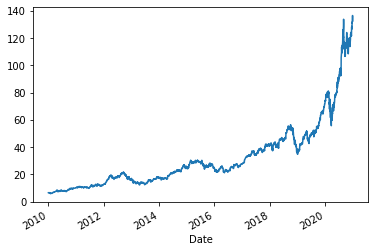

In [84]:
clean_data['Adj Close'].plot()

In [113]:
## prepare the dataset
clean_data['day'] = clean_data.index.day
clean_data['month'] = clean_data.index.month
clean_data['year'] = clean_data.index.year
clean_data['week_day'] = clean_data.index.dayofweek
clean_data['week_day_name'] = clean_data.index.strftime('%A')

In [133]:
clean_data.tail()

,High,Low,Open,Close,Volume,Adj Close,day,month,year,week_day,week_day_name
Date,,,,,,,,,,,
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087,24,12,2020,3,Thursday
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053,28,12,2020,0,Monday
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762,29,12,2020,1,Tuesday
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.520477,30,12,2020,2,Wednesday
2020-12-31,134.740005,131.720001,134.080002,132.690002,99116600.0,132.492020,31,12,2020,3,Thursday


In [160]:
clean_data.isnull().values.any()

False

In [134]:
clean_data.to_csv("apple_stock.csv")

In [124]:
def total_return(prices):
    """Retuns the return between the first and last value of the DataFrame.
    Parameters
    ----------
    prices : pandas.Series or pandas.DataFrame
    Returns
    -------
    total_return : float or pandas.Series
        Depending on the input passed returns a float or a pandas.Series.
    """
    return prices.iloc[-1] / prices.iloc[0] - 1

In [153]:
group_data = clean_data.groupby(by=['year', 'month'])['Adj Close'].apply(total_return)
group_data

year  month
2009  12       0.000000
2010  1       -0.102565
      2        0.050788
      3        0.124455
      4        0.106454
                 ...   
2020  8        0.186668
      9       -0.136906
      10      -0.067900
      11       0.096400
      12       0.081242
Name: Adj Close, Length: 133, dtype: float64

<AxesSubplot:xlabel='year,month'>

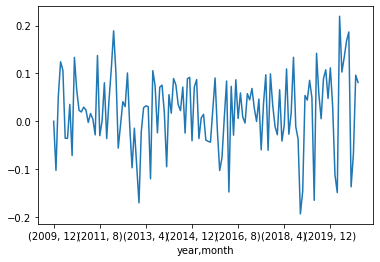

In [154]:
group_data.plot()

In [150]:
np.log(1 + group_data)  # monthly cc returns

year  month
2009  12       0.000000
2010  1       -0.108215
      2        0.049540
      3        0.117299
      4        0.101161
                 ...   
2020  8        0.171150
      9       -0.147231
      10      -0.070315
      11       0.092032
      12       0.078110
Name: Adj Close, Length: 133, dtype: float64

In [158]:
clean_data['Adj Close'].resample('M').ffill().pct_change()

Date
2009-12-31         NaN
2010-01-31   -0.088597
2010-02-28    0.065396
2010-03-31    0.148470
2010-04-30    0.111022
                ...   
2020-08-31    0.216569
2020-09-30   -0.102526
2020-10-31   -0.060012
2020-11-30    0.095493
2020-12-31    0.114574
Freq: M, Name: Adj Close, Length: 133, dtype: float64

In [164]:
np.log(clean_data['Adj Close'].resample('M').ffill().pct_change()+1)

Date
2009-12-31         NaN
2010-01-31   -0.092770
2010-02-28    0.063347
2010-03-31    0.138431
2010-04-30    0.105280
                ...   
2020-08-31    0.196035
2020-09-30   -0.108172
2020-10-31   -0.061888
2020-11-30    0.091205
2020-12-31    0.108472
Freq: M, Name: Adj Close, Length: 133, dtype: float64

`resample` method use the price of last of day of previous month to calculate the month return.

<AxesSubplot:xlabel='Date'>

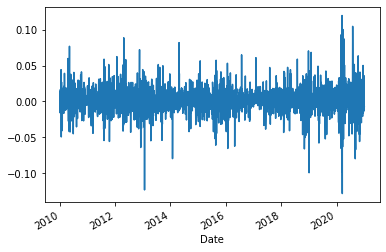

In [162]:
# daily return
clean_data['Adj Close'].pct_change().plot()

### Time Series Concepts

A stochastic process $\{ Y_t \}_{t = - \infty}^\infty$ is _strict stationary_ if, for any given finite integer $r$ and for any set of subscripts $t_1, t_2, \cdots, t_r$ the joint distribution of $(Y_{t_1}, Y_{t_2}, \cdots, Y_{t_r})$ depends only on $t_1 - t, t_2 - t, \cdots, t_r - t$ but not on $t$. 

A stochastic process $\{Y_t\}_{t=1}^\infty$ is _convariance stationary_ if 

1. $E[Y_T] = \mu$ does not depend on $t$
2. $var(Y_t) = \sigma^2$ does not depend on $t$
3. $cov(Y_t, Y_{t-j}) = \gamma_j$ exsits, is finite, and depends only on $j$ but not on $t$ for $j = 0, 1, 2, \cdots$

The term $\gamma_j$ is called the $j^{th}$ order _autocovariance_. The $j^{th}$ order autocorrelation is defined as

$$\rho_j = \frac{cov(Y_t, Y_{t-j})}{\sqrt{var(Y_t)var(Y_{t-j})}} = \frac{\gamma_j}{\sigma^2}$$

The autocovariances measure the direction of linear dependence between $Y_t$ and $Y_{t-j}$. The autocorrelations measure both the direction and strength of linear dependence between $Y_t$ and $Y_{t-j}$. 

The autocovariances and autocorrelations are measures of the linear termporal dependence in a covariance stationary stochastic process. A graphic summary of this temporal dependence is given by the plot of $\rho_j$ against $j$, and is called the _autocorrelation function_ (ACF).

One special autocovariance stationary process is the _Gaussian White Noise_, which is defined as follows: Let $Y_t \sim iid \ N(0, \sigma^2)$, Then $\{Y_t\}_{t = - \infty}^\infty$ is called a _Gaussian white noise_ process and is denoted $Y_t \sim GWN(0, \sigma^2)$. Notice that:

* $E[Y_t] = 0$ independent of $t$
* $V(Y_t) = \sigma^2$ independent of $t$
* $cov(Y_t, Y_{t-j}) = 0 $ for ($j > 0$) independent of $t$ for all $j$.

In the electrical engineering literature, white
noise represents the __absence of any signal__.

> If a time series is white noise, it is a sequence of random numbers and cannot be predicted. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
seed(156)  # see the seed

In [3]:
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)
series.describe()

count    1000.000000
mean        0.042187
std         0.979419
min        -2.715893
25%        -0.605595
50%         0.057427
75%         0.704655
max         3.108592
dtype: float64

<AxesSubplot:>

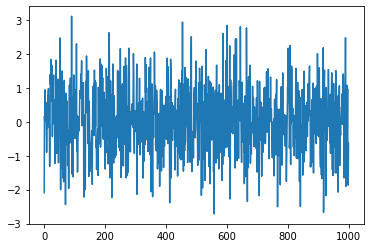

In [4]:
series.plot()

<AxesSubplot:>

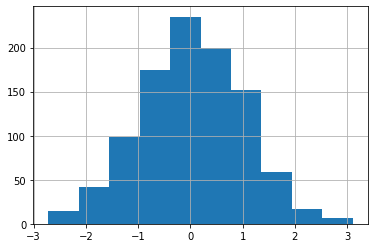

In [5]:
series.hist()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

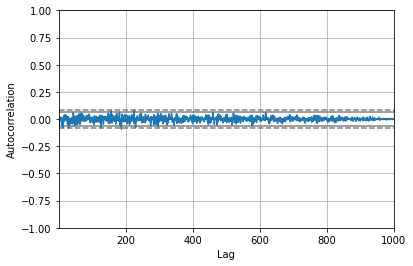

In [6]:
autocorrelation_plot(series)

#### Non-Stationary Process

In a covariance stationary stochastic process it is assumed that the means,
variances and autocovariances are independent of time. In a non-stationary
process, one or more of these assumptions is not true.

__Deterministically trending process__: $Y_t = \beta_0 + \beta_1 t + \epsilon_t, \ \ \epsilon_t \sim WN(0, \sigma_\epsilon^2)$, it is nonstationary because the mean of $Y_t$ depends on $t$:

$$E[Y_t] = \beta_0 + \beta_1 t$$

<AxesSubplot:>

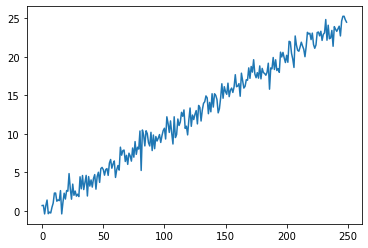

In [25]:
dtrend = [0.1 * i + gauss(0.0, 1.0) for i in range(250)]
dtrend = Series(dtrend)
dtrend.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

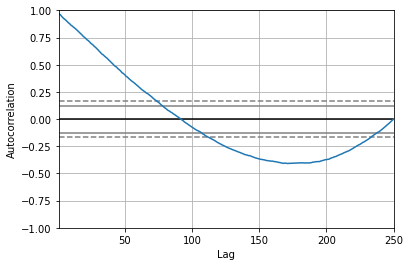

In [26]:
autocorrelation_plot(dtrend)

__Random walk__: $Y_t = Y_{t-1} + \epsilon_t, \ \epsilon_t \sim iid(0, \sigma_{\epsilon}^2)$ with $Y_0$ is fixed. By recursive substituion starting $t = 1$, we have:

$$Y_t = Y_0 + \sum_{j=1}^t \epsilon_t$$

Now, $E[Y_t] = Y_0$ which is independent of $t$. However, 

$$var(Y_t) = var(\sum_{j=1}^t \epsilon_j) = \sigma_{\epsilon}^2 \times t$$

<AxesSubplot:>

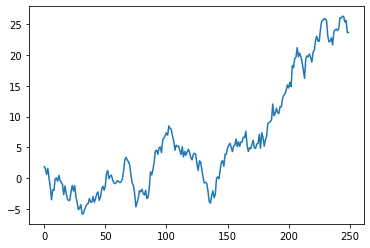

In [21]:
rwalk = [gauss(0.0, 1.0) for i in range(250)]
rwalk = Series(np.cumsum(rwalk))
rwalk.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

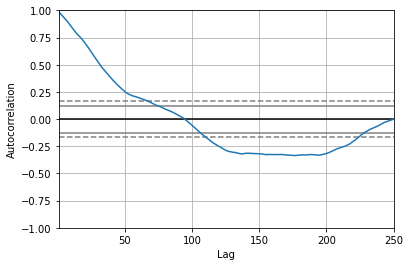

In [27]:
autocorrelation_plot(rwalk)

<AxesSubplot:>

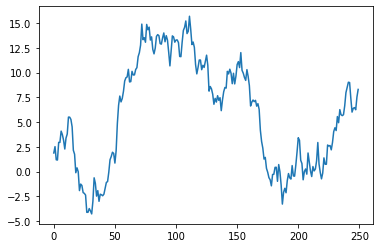

In [22]:
rwalk = [gauss(0.0, 1.0) for i in range(250)]
rwalk = Series(np.cumsum(rwalk))
rwalk.plot()

<AxesSubplot:>

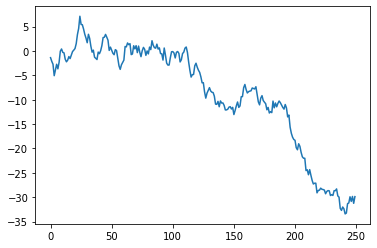

In [24]:
rwalk = [gauss(0.0, 1.0) for i in range(250)]
rwalk = Series(np.cumsum(rwalk))
rwalk.plot()

### Ergodicity

In a strictly stationary or covariance stationary stochastic process no assumption is made about the strength of dependence between random variables in
the sequence. For example, in a covariance stationary stochastic process
it is possible $\rho_1 = \rho_{100} = 0.5$. However, in many contexts it is reasonable to assume that the strength of
dependence between random variables in a stochastic process diminishes the
farther apart they become. That is $\rho_1 > \rho_2> \cdots$ and that eventually $\rho_j = 0$ for $j$ large enough.

Intuitively, a stochastic process $\{Y_t\}_{t=-\infty}^\infty$ is _ergodic_ if any two collections of random variables partitioned far apart in the sequence are essentially independent. 

The different flavors of white noise processes are not very interesting because they do not allow any linear dependence between the observations in
the series. 

But some models allow us to that, such as MA(1) and AR(1) process.

__MA(1)__: $Y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}, \ \ -1 < \theta < 1$

__AR(1)__: $Y_t - \mu =\phi(Y_{t-1} - \mu) + \varepsilon_t, \ \ -1 < \phi < 1$

Properties of MA(1):

\begin{align}
E[Y_t] & = \mu \\
var(Y_t) & = \sigma_{\epsilon}^2(1 + \theta^2) \\
cov(Y_t, Y_{t-1}) & = \theta \sigma_{\epsilon}^2 
\end{align}

MA(1) is a _covariance stationary process_ as we can
show that the mean, variance and autocovariances are time invariant. Its behiavour is determined by $\epsilon$ and $\theta$.

Properties of AR(1):

\begin{align}
E[Y_t] & = \mu \\
var(Y_t) & = \sigma_{\varepsilon}^2(1 - \phi^2) \\
cov(Y_t, Y_{t-1}) & = \phi^j
\end{align}

Notice that the restriction $|\phi| < 1$ implies that

$$\lim_{j \to \infty} \rho_j = \phi^j = 0$$

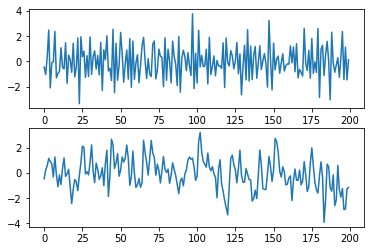

In [33]:
# plot1: ma parameter = -0.9
plt.subplot(2, 1, 1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])  # with zero lag coefficient 1
MA_object1 = sm.tsa.ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=200)
plt.plot(simulated_data_1)
plt.subplot(2, 1, 2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])  # with zero lag coefficient 1
MA_object2 = sm.tsa.ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=200)
plt.plot(simulated_data_2)

In [38]:
MA_object2.isinvertible

True

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

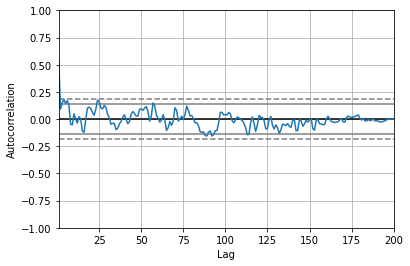

In [34]:
autocorrelation_plot(simulated_data_2)

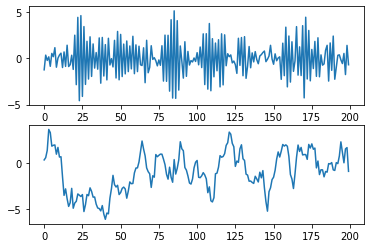

In [35]:
plt.subplot(2, 1, 1)
ar1 = np.array([1, 0.9])
ma1 = np.array([1])  # with zero lag coefficient 1
AR_object1 = sm.tsa.ArmaProcess(ar1, ma1)
simulated_data_ar1 = AR_object1.generate_sample(nsample=200)
plt.plot(simulated_data_ar1)
plt.subplot(2, 1, 2)
ar2 = np.array([1, -0.9])
ma2 = np.array([1])  # with zero lag coefficient 1
AR_object2 = sm.tsa.ArmaProcess(ar2, ma2)
simulated_data_ar2 = AR_object2.generate_sample(nsample=200)
plt.plot(simulated_data_ar2)

In [39]:
AR_object2.isinvertible

True

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

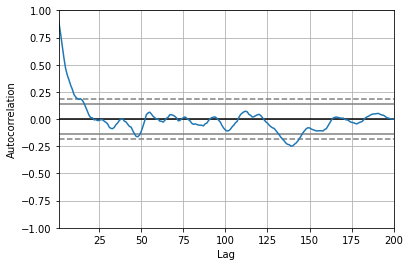

In [37]:
autocorrelation_plot(simulated_data_ar2)

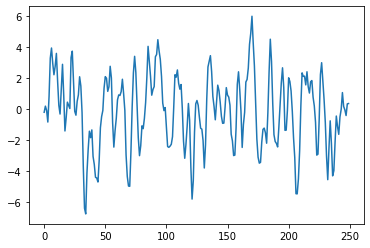

In [40]:
# ARMA(2, 2)
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)
arma_process.isstationary
y = arma_process.generate_sample(250)
plt.plot(y)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

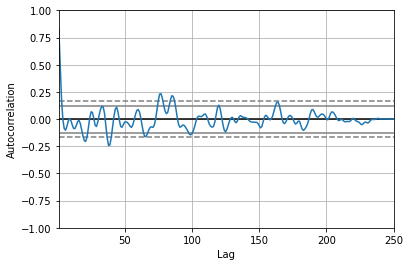

In [41]:
autocorrelation_plot(y)

### References

Return Calculations by [Zivot](https://faculty.washington.edu/ezivot/econ424/returnCalculations.pdf)